# Week 4: NLP Disaster Tweets Kaggle Mini-Project

## Project Description

The goal of this project is to forecast whether an given is actually announcing a disaster or not.  Certain words that may imply a disaster can have a different meeting depending on how it is used in a sentence.  Therefore the challange of this problem is to not only identify words that may indicate a distaster, but also look at the context of this word in relation to the rest of this sentence.
For such a task a standard machine learning or deep learning model may not be sufficient.  However a recurrent neural networks (RNNs) may provide a better tool, as this method will also look at the patterns of words.

A LTSM model based upon the tensorflow/keras library will be used to contruct this model

In [1]:
# import all necessary librarires
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Flatten, Dropout, Bidirectional
from keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import seaborn as sns

## Data Overview
The source data and project overview can be found on Kagle at https://www.kaggle.com/competitions/nlp-getting-started/overview
The data consists of three files, one with a training set to build the model, a test set to submit to Kaggle for evaluation and file containing format for teh submission.

As can be seen below the training set contains 7,613 and the test set contain 3,263 entries.
The fields that will be used for this project are text for the independent variable and target for the dependant variable.  The other fields will not be utilized.

The text field contains the actual text of the tweet, whereas the target field contains a 1 or 0 to represent whether the tweet actually referred to a distastor or not.

As can be seen below, neither of these fields contain null entries, therefore none of the entries will be removed for purposes of this project

In [2]:
training_data = pd.read_csv("data/train.csv")
testing_data = pd.read_csv("data/test.csv")
submission = pd.read_csv("data/sample_submission.csv")

In [3]:
training_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


In [4]:
testing_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3263 entries, 0 to 3262
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        3263 non-null   int64 
 1   keyword   3237 non-null   object
 2   location  2158 non-null   object
 3   text      3263 non-null   object
dtypes: int64(1), object(3)
memory usage: 102.1+ KB


In [5]:
training_data.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [6]:
testing_data.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


In [7]:
testing_data['text'].isnull().sum()

0

In [8]:
training_data['text'].isnull().sum()


0

In [9]:
training_data['target'].isnull().sum()

0

## Exploratory Data Analysis (EDA)
The data contains 7,613 non-null entriess of which 7,503 are unique.  The target field contains as expected 0's and 1's.  Therefore first pass of the data appears to be suffiecient to build a model.

Within the data set 43% of the tweets represent a positivfe result, meaning that the tweet actually refers to a real disaster.



In [10]:
training_data.describe(include='all')

,id,keyword,location,text,target
count,7613.000000,7552,5080,7613,7613.00000
unique,NaN,221,3341,7503,NaN
top,NaN,fatalities,USA,11-Year-Old Boy Charged With Manslaughter of T...,NaN
freq,NaN,45,104,10,NaN
mean,5441.934848,NaN,NaN,NaN,0.42966
std,3137.116090,NaN,NaN,NaN,0.49506
min,1.000000,NaN,NaN,NaN,0.00000
25%,2734.000000,NaN,NaN,NaN,0.00000
50%,5408.000000,NaN,NaN,NaN,0.00000
75%,8146.000000,NaN,NaN,NaN,1.00000


% of Tweets Postive: 43.0%


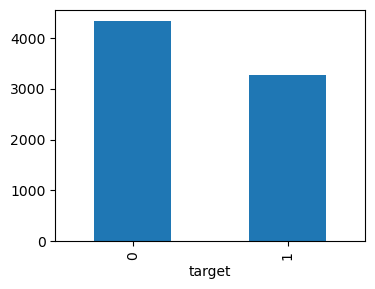

In [11]:
plt.figure(figsize=(4, 3))
training_data.target.value_counts().plot(kind='bar')
print(f'% of Tweets Postive: {round(training_data.target.value_counts()[1]/training_data.shape[0]*100,0)}%')

### Quality of the Data
Upon inspection of a sampel fo the data, it can be see that the text contains a number of non-essential information such as http sites,@ symbols as well as a combination of lower/upper case letters.


In [12]:
training_data.sample(10)

,id,keyword,location,text,target
5425,7743,panicking,Positive 852,My sis can now sit on a cam w/o panicking http...,0
3607,5149,fatal,NaN,Robert Ballew's log statements are always at t...,0
2028,2911,danger,"San Jose, California",Red Flag Warning for fire danger &amp; dry thu...,1
5817,8301,rubble,"Accra,Ghana",#360WiseNews : China's Stock Market Crash: Are...,0
7261,10395,whirlwind,Canterbury kent,Only been back 10 &amp; a whirlwind has hit ja...,0
4327,6146,hijack,NaN,REVEALED: Everton hijack United bid for 14-yea...,0
3357,4807,evacuated,West,Rocky fire in Northern California swells to 60...,1
5666,8085,rescue,Karachi,Flood-zone : General Raheel Sharif visits Chit...,1
407,585,arson,NaN,Owner of Chicago-Area Gay Bar Admits to Arson ...,1
3705,5270,fear,"Largo, MD",Men fear the feeling of being 'controlled' by ...,0


In [13]:
def clean_text(text):
    lemm=WordNetLemmatizer()
    stop_words = stopwords.words("english")
    

    
    def remove_stop(text):
        ex_stop = []
        for w in text.split(' '):
            if w not in stop_words:
                ex_stop.append(w)
        return " ".join(ex_stop)
    
    def remove_unwanted(text):
        text = re.sub(r'^RT[\s]+', '', text)
        text = re.sub(r'https?://[^\s\n\r]+', '', text)
        text = re.sub(r'#', '', text)
        text = re.sub(r'[^a-zA-Z0-9]', ' ', text)
        return text
    
    text = text.apply(lambda x:x.lower())
    text = text.apply(remove_stop)
    text = text.apply(remove_unwanted)
    text.apply(lambda x:lemm.lemmatize(x))
    

    
    return text
    

### Data Cleaning
The above function clean_text helps clean up the data by:
1. converting all letters to lower case
2. remove stop words which most likley do not influence the context
3. remove unwanted characters such as #'s and http references
4. lemmatize the data - this steps converts common words to a similiar word base

The effect of this cleaning and standardization can be see below.


In [14]:
training_data['text_clean'] = clean_text(training_data['text'])
training_data.head()

,id,keyword,location,text,target,text_clean
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1,deeds reason earthquake may allah forgive us
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,forest fire near la ronge sask canada
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1,residents asked shelter place notified offic...
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1,13 000 people receive wildfires evacuation ord...
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1,got sent photo ruby alaska smoke wildfires pou...


In [15]:
training_data.sample(10)

,id,keyword,location,text,target,text_clean
749,1081,blew%20up,NaN,I blew up #oomf instagrams cause she's cute an...,0,blew oomf instagrams cause cute active follower
730,1054,bleeding,NaN,@Uptown_Jorge head up like yo nose bleeding,0,uptown jorge head like yo nose bleeding
7246,10376,weapons,"( ?å¡ ?? ?å¡),",I liked a @YouTube video from @dannyonpc http:...,0,liked youtube video dannyonpc battlefield h...
2016,2893,damage,NaN,#JSunNews Storm damage reported in Madison Cou...,1,jsunnews storm damage reported madison county ...
5607,8001,razed,NaN,The Latest: More homes razed by #NorthernCalif...,1,latest homes razed northerncalifornia wildfir...
5202,7428,obliterated,"Danbury, CT",Uribe just obliterated a baseball.,0,uribe obliterated baseball
5771,8238,riot,Mumbai,Stuart Broad Takes Eight Before Joe Root Runs ...,0,stuart broad takes eight joe root runs riot au...
4333,6153,hijack,eating strawberry shitsickles,@mockingpanems @cuddlesforjen what if he slamm...,0,mockingpanems cuddlesforjen slammed wall wro...
4942,7044,mayhem,107-18 79TH STREET,#NoSurrender Results: Full Metal Mayhem World ...,0,nosurrender results full metal mayhem world t...
3885,5524,flattened,UK,Today (August 6th) is the 70th anniversary of ...,1,today august 6th 70th anniversary a bomb li...


## Model Building
As noted in the introduction a RNN model wil be used.  This is to allow the context of keyboards within the sentence to be better analyized.  In order to minimize the effect of the vanishing gradient problem commonly found in certain RNN models a Long short-term memory (LSTM) model will be used.  
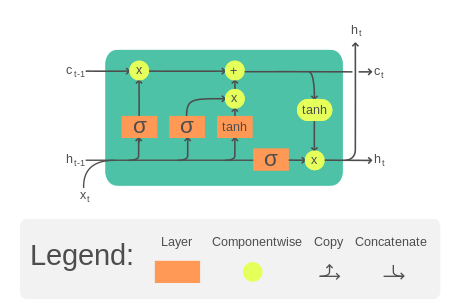
The above diagram from Wikipedia (https://en.wikipedia.org/wiki/Long_short-term_memory) illustrates the architecture of a LSTM RNN model

In [16]:
# Train_test split
TEST_SIZE=0.2
y = training_data['target']
X_train, X_val, y_train, y_val = train_test_split(training_data, y, test_size=TEST_SIZE, random_state=10) 

The tokenizer from keras is used to vectorize the text (ie. turning the text into either a sequence of integers or into a vector).  This step will improve the overall performance of the model.
The maximum number of words to keep is the primary hyper-parameter in this step

In [17]:
max_words = 10000
tokenizer = Tokenizer(num_words = max_words,oov_token = '<OOV>')
tokenizer.fit_on_texts(X_train["text_clean"])

In [18]:
max_len = 200


sequences_train = tokenizer.texts_to_sequences(X_train['text_clean'].values)
padded_train = pad_sequences(sequences_train)

sequences_val = tokenizer.texts_to_sequences(X_val['text_clean'].values)
padded_val = pad_sequences(sequences_val, maxlen=max_len, truncating='post')

### Base Model
Early stopping will be applied to avoid both overfitting and underfitting of the training dataset.
Too few iterations of the model may result in underfit model and early stopping specifies an 
arbitrary large number of training epochs and stop allow for the training to stop once the model performance stops improving


In [19]:
early_stopping = EarlyStopping(monitor='val_loss', patience=10, start_from_epoch=30)

The model will begin with two bidirectional LSTM layers.  The bidirectional step involves duplicating the first recurrent layer in the network so creating two layers side-by-side.  The first layer as is and the 2nd layer a reversed copy of the input sequence to the second.  A 128 dense later will then be generated using relu activation and finally an output layer using signoid activation.

In [20]:
model = Sequential()
model.add(Embedding(10000,128))
model.add(Bidirectional(LSTM(64,return_sequences=True)))
model.add(Bidirectional(LSTM(64)))
model.add(Dense(128,activation="relu"))
model.add(Dropout(0.4))
model.add(Dense(1,activation="sigmoid"))

In [21]:
custom_lr = 0.00003

custom_optimizer = Adam(learning_rate=custom_lr)

# Compile the model with the custom optimizer
model.compile(optimizer=custom_optimizer, loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 128)         1280000   
                                                                 
 bidirectional (Bidirection  (None, None, 128)         98816     
 al)                                                             
                                                                 
 bidirectional_1 (Bidirecti  (None, 128)               98816     
 onal)                                                           
                                                                 
 dense (Dense)               (None, 128)               16512     
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

In [22]:
history = model.fit(padded_train, y_train, epochs=100,validation_data=(padded_val, y_val),batch_size=256,
                    callbacks=early_stopping)

Epoch 1/100


24/24 [==============================] - 10s 184ms/step - loss: 0.6916 - accuracy: 0.5617 - val_loss: 0.6906 - val_accuracy: 0.5653
Epoch 2/100
24/24 [==============================] - 3s 118ms/step - loss: 0.6893 - accuracy: 0.5716 - val_loss: 0.6882 - val_accuracy: 0.5653
Epoch 3/100
24/24 [==============================] - 3s 115ms/step - loss: 0.6866 - accuracy: 0.5716 - val_loss: 0.6858 - val_accuracy: 0.5653
Epoch 4/100
24/24 [==============================] - 3s 114ms/step - loss: 0.6839 - accuracy: 0.5716 - val_loss: 0.6836 - val_accuracy: 0.5653
Epoch 5/100
24/24 [==============================] - 3s 114ms/step - loss: 0.6816 - accuracy: 0.5716 - val_loss: 0.6820 - val_accuracy: 0.5653
Epoch 6/100
24/24 [==============================] - 3s 119ms/step - loss: 0.6793 - accuracy: 0.5716 - val_loss: 0.6808 - val_accuracy: 0.5653
Epoch 7/100
24/24 [==============================] - 3s 114ms/step - loss: 0.6773 - accuracy: 0.5716 - val_loss: 0.6797 - val_accuracy: 0.5

## Results and Analysis 
The intial model produce a low F1 score on the evaluation data, with a near 100% on the training data, this may indicate that the model is overfitting.  The divergence can be see in the graphs as well below.

In [23]:
f1_scores = []
y_pred = model.predict(padded_val)
y_pred = (y_pred > 0.5).astype(int)

f1 = f1_score(X_val['target'], y_pred)
print(f"F1 Score: {f1}")

f1_scores.append( {'Base Model',f1_score(X_val['target'], y_pred)})

48/48 [==============================] - 3s 36ms/step
F1 Score: 0.5367965367965368


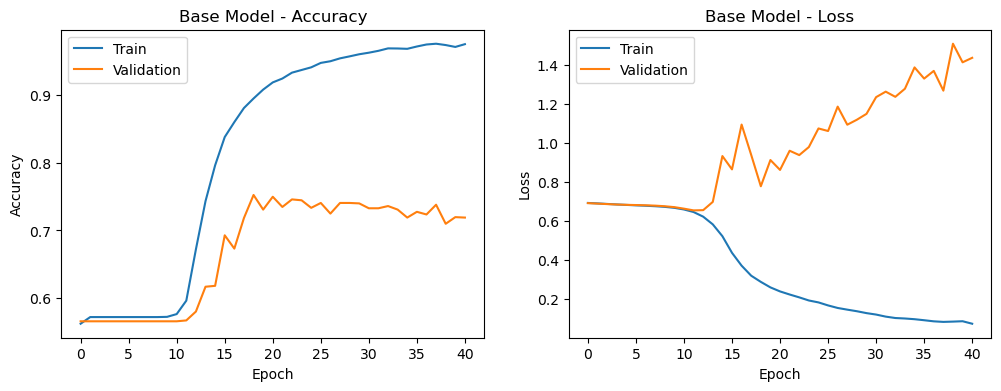

In [24]:
fig , ax = plt.subplots(1,2)
fig.set_size_inches(12,4)

ax[0].plot(history.history['accuracy'])
ax[0].plot(history.history['val_accuracy'])
ax[0].set_title('Base Model - Accuracy')
ax[0].set_ylabel('Accuracy')
ax[0].set_xlabel('Epoch')
ax[0].legend(['Train', 'Validation'], loc='upper left')

ax[1].plot(history.history['loss'])
ax[1].plot(history.history['val_loss'])
ax[1].set_title('Base Model - Loss')
ax[1].set_ylabel('Loss')
ax[1].set_xlabel('Epoch')
ax[1].legend(['Train', 'Validation'], loc='upper left')

### Alternate Model
In order to attempt to minimize the over-fitting from the base model an alternate version is presented below


4 Variations on the base model are done below:

Variant 1 - Additional Dense Layer

Variant 2 - Reduce the learning rate on model 1 by a factor of 100

Variant 3 - Additional Dense Layer on Variant 1

Variant 4 - One more dense layer on Variant 3

In [25]:
# model1 1



max_words = 10000
tokenizer = Tokenizer(num_words = max_words,oov_token = '<OOV>')
tokenizer.fit_on_texts(X_train["text_clean"])
max_len = 200
sequences_train = tokenizer.texts_to_sequences(X_train['text_clean'].values)
padded_train = pad_sequences(sequences_train)
sequences_val = tokenizer.texts_to_sequences(X_val['text_clean'].values)
padded_val = pad_sequences(sequences_val, maxlen=max_len, truncating='post')


model1 = Sequential()
model1.add(Embedding(10000,128))
model1.add(Bidirectional(LSTM(64,return_sequences=True)))
model1.add(Bidirectional(LSTM(64)))
model1.add(Dropout(0.5))
model1.add(Flatten())
model1.add(Dense(128,activation="relu"))
model1.add(Dropout(0.4))
model1.add(Dense(64, activation = 'relu'))
model1.add(Dropout(0.5))
model1.add(Dense(1,activation="sigmoid"))

custom_lr = 0.00003
custom_optimizer = Adam(learning_rate=custom_lr)
model1.compile(optimizer=custom_optimizer, loss='binary_crossentropy', metrics=['accuracy'])
history = model1.fit(padded_train, y_train, epochs=100,validation_data=(padded_val, y_val),batch_size=256,
                    callbacks=early_stopping)

Epoch 1/100
24/24 [==============================] - 10s 177ms/step - loss: 0.6927 - accuracy: 0.5176 - val_loss: 0.6915 - val_accuracy: 0.5653
Epoch 2/100
24/24 [==============================] - 3s 113ms/step - loss: 0.6905 - accuracy: 0.5594 - val_loss: 0.6896 - val_accuracy: 0.5653
Epoch 3/100
24/24 [==============================] - 3s 114ms/step - loss: 0.6886 - accuracy: 0.5652 - val_loss: 0.6875 - val_accuracy: 0.5653
Epoch 4/100
24/24 [==============================] - 3s 113ms/step - loss: 0.6871 - accuracy: 0.5708 - val_loss: 0.6855 - val_accuracy: 0.5653
Epoch 5/100
24/24 [==============================] - 3s 115ms/step - loss: 0.6849 - accuracy: 0.5722 - val_loss: 0.6836 - val_accuracy: 0.5653
Epoch 6/100
24/24 [==============================] - 3s 117ms/step - loss: 0.6822 - accuracy: 0.5716 - val_loss: 0.6820 - val_accuracy: 0.5653
Epoch 7/100
24/24 [==============================] - 3s 114ms/step - loss: 0.6826 - accuracy: 0.5719 - val_loss: 0.6811 - val_accuracy: 0.565

48/48 [==============================] - 3s 36ms/step


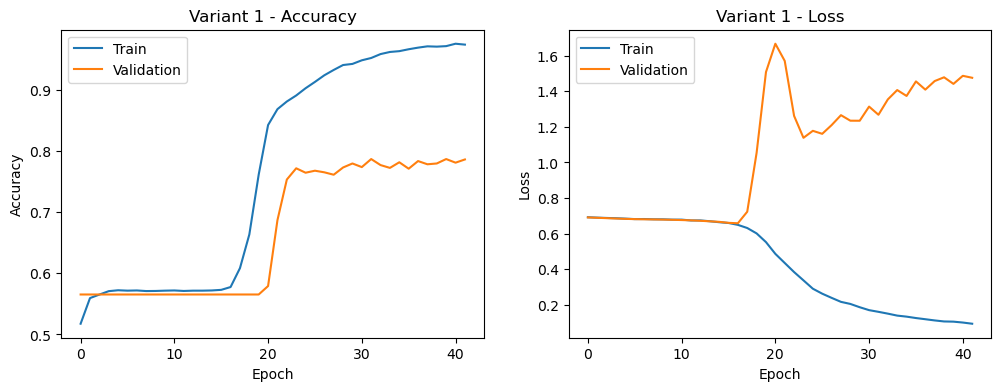

In [26]:
y_pred = model1.predict(padded_val)
y_pred = (y_pred > 0.5).astype(int)

f1_scores.append( {'Variant 1',f1_score(X_val['target'], y_pred)})

fig , ax = plt.subplots(1,2)
fig.set_size_inches(12,4)


ax[0].plot(history.history['accuracy'])
ax[0].plot(history.history['val_accuracy'])
ax[0].set_title('Variant 1 - Accuracy')
ax[0].set_ylabel('Accuracy')
ax[0].set_xlabel('Epoch')
ax[0].legend(['Train', 'Validation'], loc='upper left')

ax[1].plot(history.history['loss'])
ax[1].plot(history.history['val_loss'])
ax[1].set_title('Variant 1 - Loss')
ax[1].set_ylabel('Loss')
ax[1].set_xlabel('Epoch')
ax[1].legend(['Train', 'Validation'], loc='upper left')

In [27]:
# Model 2

max_words = 10000
tokenizer = Tokenizer(num_words = max_words,oov_token = '<OOV>')
tokenizer.fit_on_texts(X_train["text_clean"])
max_len = 200
sequences_train = tokenizer.texts_to_sequences(X_train['text_clean'].values)
padded_train = pad_sequences(sequences_train)
sequences_val = tokenizer.texts_to_sequences(X_val['text_clean'].values)
padded_val = pad_sequences(sequences_val, maxlen=max_len, truncating='post')


model2 = Sequential()
model2.add(Embedding(10000,128))
model2.add(Bidirectional(LSTM(64,return_sequences=True)))
model2.add(Bidirectional(LSTM(64)))
model2.add(Dropout(0.5))
model2.add(Flatten())
model2.add(Dense(128,activation="relu"))
model2.add(Dropout(0.4))
model2.add(Dense(64, activation = 'relu'))
model2.add(Dropout(0.5))
model2.add(Dense(1,activation="sigmoid"))

custom_lr = 0.003
custom_optimizer = Adam(learning_rate=custom_lr)
model2.compile(optimizer=custom_optimizer, loss='binary_crossentropy', metrics=['accuracy'])
history = model2.fit(padded_train, y_train, epochs=100,validation_data=(padded_val, y_val),batch_size=256,
                    callbacks=early_stopping)

Epoch 1/100
24/24 [==============================] - 9s 169ms/step - loss: 0.6303 - accuracy: 0.6335 - val_loss: 0.4675 - val_accuracy: 0.7879
Epoch 2/100
24/24 [==============================] - 3s 120ms/step - loss: 0.3408 - accuracy: 0.8701 - val_loss: 0.4843 - val_accuracy: 0.7938
Epoch 3/100
24/24 [==============================] - 3s 117ms/step - loss: 0.2049 - accuracy: 0.9307 - val_loss: 0.6629 - val_accuracy: 0.7695
Epoch 4/100
24/24 [==============================] - 3s 116ms/step - loss: 0.1409 - accuracy: 0.9542 - val_loss: 0.7931 - val_accuracy: 0.7754
Epoch 5/100
24/24 [==============================] - 3s 115ms/step - loss: 0.1132 - accuracy: 0.9645 - val_loss: 0.8854 - val_accuracy: 0.7446
Epoch 6/100
24/24 [==============================] - 3s 115ms/step - loss: 0.0791 - accuracy: 0.9706 - val_loss: 1.1794 - val_accuracy: 0.7649
Epoch 7/100
24/24 [==============================] - 3s 116ms/step - loss: 0.0633 - accuracy: 0.9788 - val_loss: 1.2693 - val_accuracy: 0.7656

48/48 [==============================] - 3s 37ms/step


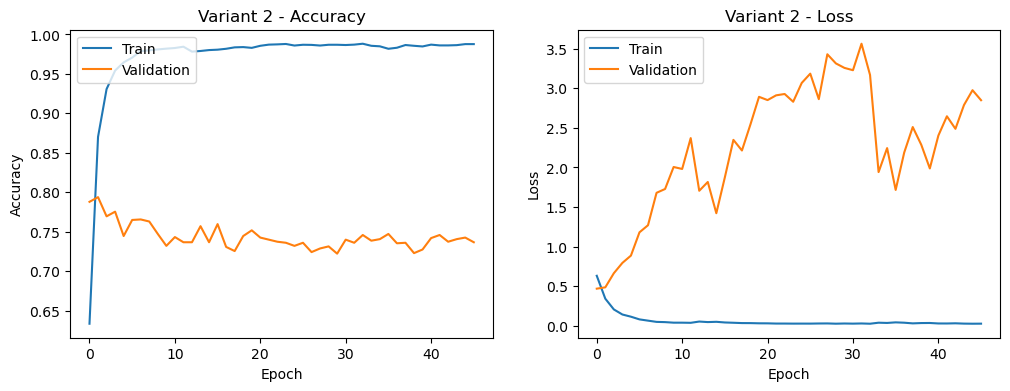

In [28]:
y_pred = model2.predict(padded_val)
y_pred = (y_pred > 0.5).astype(int)

f1_scores.append( {'Variant 2',f1_score(X_val['target'], y_pred)})

fig , ax = plt.subplots(1,2)
fig.set_size_inches(12,4)

ax[0].plot(history.history['accuracy'])
ax[0].plot(history.history['val_accuracy'])
ax[0].set_title('Variant 2 - Accuracy')
ax[0].set_ylabel('Accuracy')
ax[0].set_xlabel('Epoch')
ax[0].legend(['Train', 'Validation'], loc='upper left')

ax[1].plot(history.history['loss'])
ax[1].plot(history.history['val_loss'])
ax[1].set_title('Variant 2 - Loss')
ax[1].set_ylabel('Loss')
ax[1].set_xlabel('Epoch')
ax[1].legend(['Train', 'Validation'], loc='upper left')

In [29]:
# Model 3

max_words = 10000
tokenizer = Tokenizer(num_words = max_words,oov_token = '<OOV>')
tokenizer.fit_on_texts(X_train["text_clean"])
max_len = 200
sequences_train = tokenizer.texts_to_sequences(X_train['text_clean'].values)
padded_train = pad_sequences(sequences_train)
sequences_val = tokenizer.texts_to_sequences(X_val['text_clean'].values)
padded_val = pad_sequences(sequences_val, maxlen=max_len, truncating='post')


model3 = Sequential()
model3.add(Embedding(10000,128))
model3.add(Bidirectional(LSTM(64,return_sequences=True)))
model3.add(Bidirectional(LSTM(64)))
model3.add(Dropout(0.5))
model3.add(Flatten())
model3.add(Dense(128,activation="relu"))
model3.add(Dropout(0.4))
model3.add(Dense(64, activation = 'relu'))
model3.add(Dropout(0.5))
model3.add(Dense(32, activation = 'relu'))
model3.add(Dropout(0.5))
model3.add(Dense(1,activation="sigmoid"))
custom_lr = 0.00003
custom_optimizer = Adam(learning_rate=custom_lr)
model3.compile(optimizer=custom_optimizer, loss='binary_crossentropy', metrics=['accuracy'])
history = model3.fit(padded_train, y_train, epochs=100,validation_data=(padded_val, y_val),batch_size=256,
                    callbacks=early_stopping)

Epoch 1/100
24/24 [==============================] - 10s 176ms/step - loss: 0.6912 - accuracy: 0.5539 - val_loss: 0.6919 - val_accuracy: 0.5653
Epoch 2/100
24/24 [==============================] - 3s 119ms/step - loss: 0.6900 - accuracy: 0.5581 - val_loss: 0.6908 - val_accuracy: 0.5653
Epoch 3/100
24/24 [==============================] - 3s 118ms/step - loss: 0.6890 - accuracy: 0.5654 - val_loss: 0.6895 - val_accuracy: 0.5653
Epoch 4/100
24/24 [==============================] - 3s 118ms/step - loss: 0.6879 - accuracy: 0.5631 - val_loss: 0.6882 - val_accuracy: 0.5653
Epoch 5/100
24/24 [==============================] - 3s 118ms/step - loss: 0.6867 - accuracy: 0.5668 - val_loss: 0.6868 - val_accuracy: 0.5653
Epoch 6/100
24/24 [==============================] - 3s 116ms/step - loss: 0.6855 - accuracy: 0.5647 - val_loss: 0.6854 - val_accuracy: 0.5653
Epoch 7/100
24/24 [==============================] - 3s 115ms/step - loss: 0.6851 - accuracy: 0.5644 - val_loss: 0.6842 - val_accuracy: 0.565

48/48 [==============================] - 3s 37ms/step


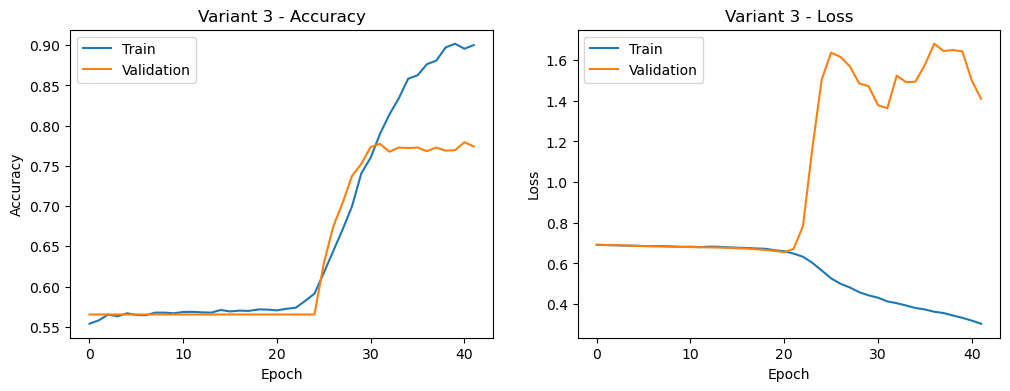

In [30]:
y_pred = model3.predict(padded_val)
y_pred = (y_pred > 0.5).astype(int)

f1_scores.append( {'Variant 3',f1_score(X_val['target'], y_pred)})

fig , ax = plt.subplots(1,2)
fig.set_size_inches(12,4)

ax[0].plot(history.history['accuracy'])
ax[0].plot(history.history['val_accuracy'])
ax[0].set_title('Variant 3 - Accuracy')
ax[0].set_ylabel('Accuracy')
ax[0].set_xlabel('Epoch')
ax[0].legend(['Train', 'Validation'], loc='upper left')

ax[1].plot(history.history['loss'])
ax[1].plot(history.history['val_loss'])
ax[1].set_title('Variant 3 - Loss')
ax[1].set_ylabel('Loss')
ax[1].set_xlabel('Epoch')
ax[1].legend(['Train', 'Validation'], loc='upper left')

In [31]:
# Model 4

max_words = 10000
tokenizer = Tokenizer(num_words = max_words,oov_token = '<OOV>')
tokenizer.fit_on_texts(X_train["text_clean"])
max_len = 200
sequences_train = tokenizer.texts_to_sequences(X_train['text_clean'].values)
padded_train = pad_sequences(sequences_train)
sequences_val = tokenizer.texts_to_sequences(X_val['text_clean'].values)
padded_val = pad_sequences(sequences_val, maxlen=max_len, truncating='post')


model4 = Sequential()
model4.add(Embedding(10000,128))
model4.add(Bidirectional(LSTM(64,return_sequences=True)))
model4.add(Bidirectional(LSTM(64)))
model4.add(Dropout(0.5))
model4.add(Flatten())
model4.add(Dense(128,activation="relu"))
model4.add(Dropout(0.4))
model4.add(Dense(64, activation = 'relu'))
model4.add(Dropout(0.5))
model4.add(Dense(32, activation = 'relu'))
model4.add(Dropout(0.5))
model4.add(Dense(16, activation = 'relu'))
model4.add(Dropout(0.4))
model4.add(Dense(1,activation="sigmoid"))

custom_lr = 0.00003
custom_optimizer = Adam(learning_rate=custom_lr)
model4.compile(optimizer=custom_optimizer, loss='binary_crossentropy', metrics=['accuracy'])
history = model4.fit(padded_train, y_train, epochs=100,validation_data=(padded_val, y_val),batch_size=256,
                    callbacks=early_stopping)

Epoch 1/100
24/24 [==============================] - 10s 175ms/step - loss: 0.6914 - accuracy: 0.5445 - val_loss: 0.6917 - val_accuracy: 0.5653
Epoch 2/100
24/24 [==============================] - 3s 120ms/step - loss: 0.6902 - accuracy: 0.5473 - val_loss: 0.6907 - val_accuracy: 0.5653
Epoch 3/100
24/24 [==============================] - 3s 119ms/step - loss: 0.6896 - accuracy: 0.5537 - val_loss: 0.6897 - val_accuracy: 0.5653
Epoch 4/100
24/24 [==============================] - 3s 120ms/step - loss: 0.6885 - accuracy: 0.5586 - val_loss: 0.6887 - val_accuracy: 0.5653
Epoch 5/100
24/24 [==============================] - 3s 117ms/step - loss: 0.6878 - accuracy: 0.5568 - val_loss: 0.6878 - val_accuracy: 0.5653
Epoch 6/100
24/24 [==============================] - 3s 116ms/step - loss: 0.6869 - accuracy: 0.5575 - val_loss: 0.6869 - val_accuracy: 0.5653
Epoch 7/100
24/24 [==============================] - 3s 117ms/step - loss: 0.6870 - accuracy: 0.5553 - val_loss: 0.6864 - val_accuracy: 0.565

48/48 [==============================] - 3s 36ms/step


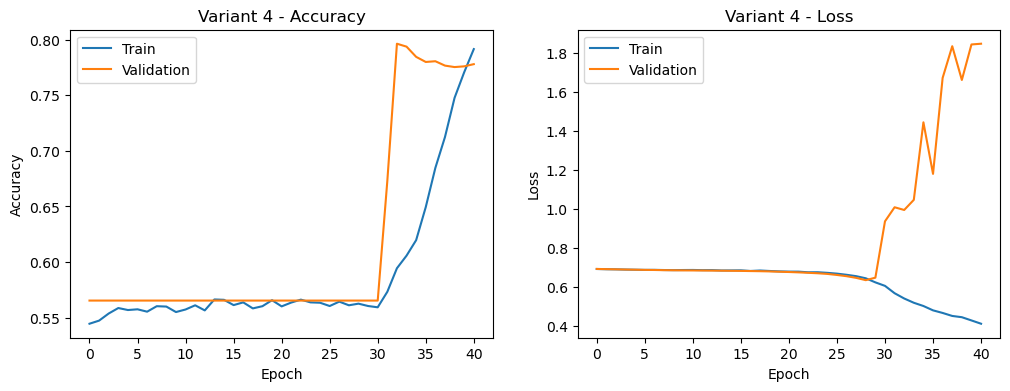

In [32]:
y_pred = model4.predict(padded_val)
y_pred = (y_pred > 0.5).astype(int)

f1_scores.append( {'Variant 4',f1_score(X_val['target'], y_pred)})

fig , ax = plt.subplots(1,2)
fig.set_size_inches(12,4)

ax[0].plot(history.history['accuracy'])
ax[0].plot(history.history['val_accuracy'])
ax[0].set_title('Variant 4 - Accuracy')
ax[0].set_ylabel('Accuracy')
ax[0].set_xlabel('Epoch')
ax[0].legend(['Train', 'Validation'], loc='upper left')

ax[1].plot(history.history['loss'])
ax[1].plot(history.history['val_loss'])
ax[1].set_title('Variant 4 - Loss')
ax[1].set_ylabel('Loss')
ax[1].set_xlabel('Epoch')
ax[1].legend(['Train', 'Validation'], loc='upper left')

## Conclusion
Based upon the model variants is appeears that improvements on the base model are possible.
- In the first variante the additionn of an additional had a significant improvement in the F1 score.  The addition of this layer resulted in increaed improvments in the validation accuracy in later epochs.
- In the 2nd variante, it be can be seen that a reduction in the training rate has an adverse impact on the results.  The validation error appears to bounce up an down, without any real improvements
- In the 3rd variante, adding one more Dense leayer resulted in a margain improvement in teh results.
- However addiing yet one more layer as with Variant 4, had an adverse impact on the results.  


Overall the 3rd variante resulted in the best performance and is used for the Kaggle submission

In [33]:
print (f1_scores)

[{0.5367965367965368, 'Base Model'}, {0.7057761732851985, 'Variant 1'}, {0.6903474903474903, 'Variant 2'}, {0.7203252032520325, 'Variant 3'}, {0.71160409556314, 'Variant 4'}]


In [34]:
testing_data['text_clean'] = clean_text(testing_data['text'])
testing_data.head()

,id,keyword,location,text,text_clean
0,0,NaN,NaN,Just happened a terrible car crash,happened terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s...",heard earthquake different cities stay safe e...
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are...",forest fire spot pond geese fleeing across st...
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires,apocalypse lighting spokane wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan,typhoon soudelor kills 28 china taiwan


In [35]:
sequences_test = tokenizer.texts_to_sequences(testing_data['text_clean'].values)
padded_test = pad_sequences(sequences_test,maxlen=max_len, truncating='post')

In [39]:
# predict testing results
pred_prob = model3.predict(padded_test)
pred_prob = np.transpose(pred_prob)[0]
y_pred = list(map(lambda x: 0 if x < 0.5 else 1, pred_prob))

102/102 [==============================] - 4s 34ms/step


In [40]:
submission["target"] = y_pred

In [41]:
submission.to_csv("submission.csv", index=False)